# A Plot of Brownian Noise
<img src="brownian-noise.png" alt="A Plot of Brownian Noise" style="width: 350px; float: right;"/>
This notebook illustrates some of the behaviors of the Singular Value Decomposition of time series data. I've written it in part as a response to [a paper](https://arxiv.org/pdf/1606.07772v2.pdf) by Andrew J. Reagan, Lewis Mitchell, Dilan Kiley, Christopher M. Danforth, and Peter Sheridan Dodds recapitulating the argument, first made by Matt Jockers, that certain kinds of eigendecompositions of sentiment data from works of fiction will reveal "fundamental plot structures" or "narrative arcs."

As I've [written elsewhere](http://www.lagado.name/blog/sine-of-the-times/), I have doubts about this approach, and initially, Reagan et. al. seemed to address them. But as I've gone over their paper more carefully, I have come to the opposite conclusion: I think they have actually shown that sentiment time series data from works of fiction is best modeled by a special kind of noise.

### Singular Value Decomposition and latent structure

In my initial response to Jockers' work, I emphasized that we had no particular reason to assume that a sinusoidal decomposition would reflect anything meaningful about plot. Until we could justify that assumption, I argued, we could not draw meaningful conclusions from a Fourier transform: we would not know what we were seeing. But Reagan et. al. use a different approach. They take the Singular Value Decomposition (SVD) of sentiment time series that they extracted from many hundreds of works from Project Gutenberg. By doing so, they avoid making the assumptions that the Fourier transform imposes, because the SVD imposes no particular structure on the decomposition that it produces.

When I saw that the SVD also produces sinusoidal functions from their sentiment time series data, I was startled, and began to reconsider my position on Jockers' original work. But then I learned that there is a [mathematical proof](https://en.wikipedia.org/wiki/Karhunen%E2%80%93Lo%C3%A8ve_theorem#The_Wiener_process) that the canonical form taken by the SVD of a special kind of noise, Brownian noise, is a set of Fourier-like sinusoidal functions.

The following code and comments show how many of the results reported in Reagan et. al. can be reproduced by simply transforming Brownian noise. I have not yet reproduced all the results reported in the paper, but I suspect that the clustering patterns they find will be easy to reproduce with pure noise, and the self-organizing map they use is difficult to interpret. The most compelling argument they provide for their thesis relies on the way the singular values produced by SVD differ when "word salad" sentiment data is substituted in place of the sentiment data from the original texts. But as I show below, that difference can be replicated simply by rescaling the data.

Furthermore, I show some evidence that if there _were_ fundamental plot structures that did not have a purely sinusoidal shape, they would likely be revealed immediately by the SVD. Instead of generating purely random noise, I randomly choose three fixed "fundamental plots" and add Brownian noise to them. Instead of producing sinusoidal shapes, the SVD of the resulting data produces more complicated base functions. The fact that no such functions appear in Reagan et. al. strongly suggests that the harmonic structures that exist in the data are purely sinusoidal, and have no particular significance beyond their significance as signs of Brownian noise.

### Global randomness vs. local structure

None of this necessarily means that there are _not_ any fundamental plot structures. Nor does it necessarily mean that there are not other "laws" of plot that we have not yet discovered. It does suggest, however, that by continuing to analyze sentiment time series data this way, we are barking up the wrong tree.

The simplest possible explanation of all the sentiment time series findings I've seen so far is that the sentiment arcs of works of fiction are, in general, simply random walks. To produce findings of any significance, these methods will need to show phenomena that cannot easily be explained by that model.

On the other hand, the structures of fiction belonging to _particular genres_, of fiction written at _particular times_, and of fiction created by _particular writers or schools of writers_ may not be modeled by random walks. The random walk model may even imply that we should _expect_ local regularities at a given time scale. Patterns of imitation and historical influence might be traceable using sentiment analysis. I think that's an approach with tremendous potential for historically informed inquiry. It's a shame that instead, scholars are continuing to look for universal laws where there probably are none. 

This is a work in progress, and I would appreciate feedback of any kind, as well as citations to other work that covers similar ground.

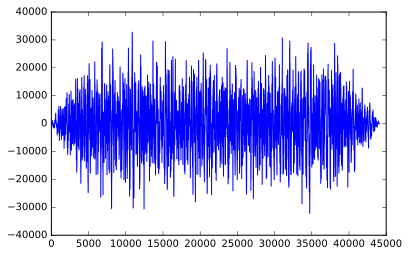

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

import numpy
import scipy
from scipy.io import wavfile
from scipy import signal

class Noise(object):
    def __init__(self, duration=1, sample_rate=44100):
        self.duration = duration
        self.sample_rate = sample_rate
        self.samples = None
        self.resample()
        
    @property
    def n_samples(self):
        return int(self.duration * self.sample_rate)

    def resample(self, amplitude=1):
        """Take a series of random samples from a gaussian distribution."""
        samples = numpy.random.normal(-1, 1, self.n_samples) #amplitude, self.n_samples)
        samples -= samples.mean()
        self.samples = samples
    
    def integrate(self):
        """'Integrate' (i.e. do a cumulative sum of) the current sample set.
        This is useful because integrating white noise produces Brownian
        noise. 
        
        There's a wonderfully concrete way to understand that fact. Imagine 
        you're a particle that wiggles, and that each time you move, you 
        decide how to move by taking a sample from a Gaussian distribution. 
        If you plotted all your movements by starting from zero each time,
        you'd get a white noise (Gaussian noise) pattern. But if you plotted
        the resulting path, you'd get a Brownian noise pattern. The
        resulting path is just the sum of the individual movements; hence
        integrating (summing) white noise produces Brownian noise.
        """
        self.samples[:] = self.samples.cumsum()
        self.samples -= self.samples.mean()
        return self
    
    def butter_high(self, freq=2 ** -8, order=1):
        b, a = signal.butter(order, freq, 'high', analog=False)
        self.samples[:] = signal.lfilter(b, a, self.samples)
        return self

    def butter_low(self, freq=2 ** -1, order=1):
        b, a = signal.butter(order, freq, 'low', analog=False)
        self.samples[:] = signal.lfilter(b, a, self.samples)
        return self
    
    def butter_filter(self, lowpass=2 ** -1, highpass=2 ** -8, order=1):
        """Perform a high- and low-pass butterworth filter.
        """
        self.butter_low(lowpass, order)
        self.butter_high(highpass, order)
        return self

    def gauss_filter(self, sample_width=0.002):
        """Convolve with a unit area Gaussian kernel. This is the 
        same thing as a weighted moving average with a Gaussian 
        weight curve.
        """
        sample_width = int(self.sample_rate * sample_width)
        kernel = numpy.exp(-numpy.linspace(-3, 3, sample_width) ** 2)
        kernel /= kernel.sum()
        self.samples[:] = signal.convolve(self.samples, kernel, 'same')
        return self
    
    def square_filter(self, sample_width=0.002):
        """Convolve with a unit area constant kernel. This is the 
        same thing as an unweighted moving average.
        """
        sample_width = int(self.sample_rate * sample_width)
        kernel = numpy.exp(-numpy.linspace(-3, 3, sample_width) ** 2)
        kernel /= kernel.sum()
        self.samples[:] = signal.convolve(self.samples, kernel, 'same')
        return self
    
    def fade(self, sample_width=0.1):
        """Fade in at the beginning and out at the end. This softens the
        percieved 'click' at the beginning and end of the noise.
        """
        sample_width = int(self.sample_rate * sample_width)
        self.samples[:sample_width] *= numpy.linspace(0, 1, sample_width)
        self.samples[-sample_width:] *= numpy.linspace(1, 0, sample_width)
        return self

    def scale(self):
        """Scale the current data by the absolute maximum. This maximizes
        volume without causing clipping artifacts.
        """
        self.samples -= self.samples.mean()
        self.samples /= numpy.max(numpy.abs(self.samples))
        self.samples *= 32767  # max amplitude at 16 bits per sample
        return self
        
    def amplify(self, amplitude=1):
        """Amplify the tone using the settings passed in by the class
        constructor. This may produce clipping.
        """
        self.samples *= self.amplitude
        return self
    
    def wav(self):
        """Return data suitable for saving as a PCM or .wav file."""
        return numpy.int16(self.samples)
    
    def _mk_sample(self, amplitude=1, filtered=False, faded=False, brownian=False,
                   gaussfilter=False, squarefilter=False, sample_width=0.002):
        self.resample(amplitude)
        self.integrate() if brownian else None
        self.gauss_filter(sample_width) if gaussfilter else None
        self.square_filter(sample_width) if squarefilter else None
        self.butter_filter(order=5) if filtered else None
        self.fade() if faded else None
        self.scale()
        return self
    
    def brownian(self, amplitude=1, filtered=False, faded=False):
        """Convenience method for generating Brownian noise."""
        return self._mk_sample(amplitude, filtered, faded, brownian=True)
    
    def brownian_gaussfilter(self, amplitude=1, filtered=False, faded=False, sample_width=0.002):
        """Conveninence method for generating Brownian noise
        passed through a gaussian filter. This produces
        especially soothing 'white' noise.
        """
        return self._mk_sample(amplitude, filtered, faded, brownian=True, 
                               gaussfilter=True, sample_width=sample_width)
    
    def brownian_squarefilter(self, amplitude=1, filtered=False, faded=False, sample_width=0.002):
        """Convenience method for generating Brownian noise passed
        through a square filter.
        """
        return self._mk_sample(amplitude, filtered, faded, brownian=True, 
                               squarefilter=True, sample_width=sample_width)

    def white(self, amplitude=1, filtered=False, faded=False):
        """Convenience method for generating white noise."""
        return self._mk_sample(amplitude, filtered, faded)
    
    def white_gaussfilter(self, amplitude=1, filtered=False, faded=False, sample_width=0.002):
        """Convenience method for generating white noise passed
        through a gaussian filter.
        """
        return self._mk_sample(amplitude, filtered, faded, gaussfilter=True, 
                               sample_width=sample_width)

    def white_squarefilter(self, amplitude=1, filtered=False, faded=False, sample_width=0.002):
        """Convenience function for generating white noise passed
        through a square filter.
        """
        return self._mk_sample(amplitude, filtered, faded, squarefilter=True, 
                               sample_width=sample_width)

    
noise = Noise(duration=1)
noise.brownian(filtered=True, faded=True)
plt.plot(noise.wav())
plt.show()
#wavfile.write('test.wav', noise.sample_rate, noise.wav())

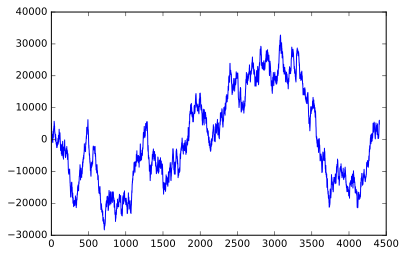

In [2]:
noise = Noise(duration=0.1)
samples = numpy.hstack([noise.brownian().wav().reshape(-1, 1) 
                        for x in range(2000)])
plt.plot(samples[:,0])
plt.show()

In [3]:
# Perform Singular Value Decomposition on the samples generated above.
# The shape of the basis vector functions is not predetermined; if you
# pass in white noise, they also look like white noise. But if you pass
# in Brownian noise, they look just like the basis functions of a 
# Fourier transform! This is mathematically provable; see the discussion
# of Wiener Processes (i.e. processes that generate Brownian noise) here: 
#
# https://en.wikipedia.org/wiki/Karhunen%E2%80%93Lo%C3%A8ve_theorem

U, s, V = numpy.linalg.svd(samples, full_matrices=False)

# This verifies that the SVD operation has produced reasonable results:

numpy.allclose(samples, U @ numpy.diag(s) @ V)

True

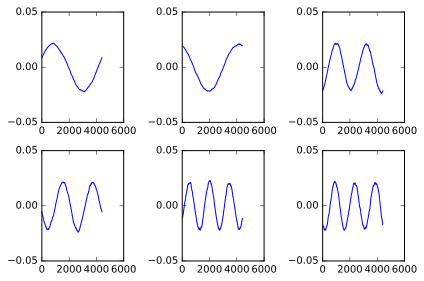

In [4]:
xbins = 3
ybins = 3
plt.subplot(2, 3, 1)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,0].reshape(-1))
plt.subplot(2, 3, 2)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,1].reshape(-1))
plt.subplot(2, 3, 3)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,2].reshape(-1))
plt.subplot(2, 3, 4)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,3].reshape(-1))
plt.subplot(2, 3, 5)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,4].reshape(-1))
plt.subplot(2, 3, 6)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,5].reshape(-1))
plt.tight_layout()
plt.show()

# Here are a few of the most significant basis functions. They 
# might be a little off -- frequently they are not centered in 
# the way one might expect. But they consistently look like 
# slightly fuzzy sinusoidal curves with increasing frequencies.

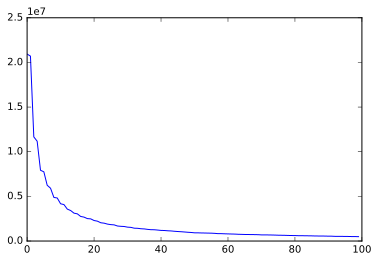

In [5]:
# This indicates how significant each of the basis functions
# are. As you can see, their significance drops off exponentially.
# The rate of drop-off can be modified by increasing or decreasing
# the overall power of the noise.

plt.plot(s[0:100])
plt.show()

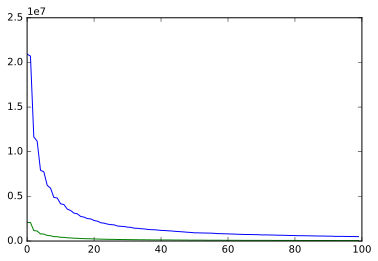

In [6]:
# It's easy enough to produce basis functions with lower singular
# values. You just reduce the amplitude. Here's the original set
# of singular values plotted against a muted version of 
# the same data. The difference that Reagan et. al. argue shows
# "less important ordering of the singular vectors" can easily
# be reproduced just by rescaling the data.

samples_low = samples / 10
U_low, s_low, V_low = numpy.linalg.svd(samples_low, full_matrices=False)
plt.plot(s[0:100])
plt.plot(s_low[0:100])
plt.show()

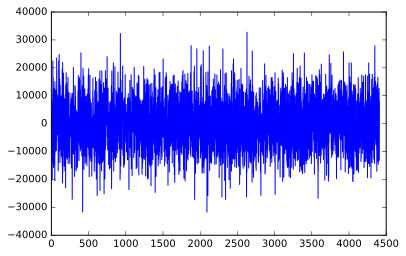

In [7]:
# When you perform SVD on white noise, the 
# basis functions are just more white noise.

noise = Noise(duration=0.1)
samples = numpy.hstack([noise.white().wav().reshape(-1, 1) 
                        for x in range(2000)])
plt.plot(samples[:,0])
plt.show()

In [8]:
U, s, V = numpy.linalg.svd(samples, full_matrices=False)
numpy.allclose(samples, U @ numpy.diag(s) @ V)

True

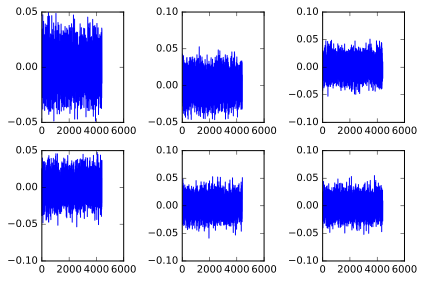

In [9]:
xbins = 3
ybins = 5
plt.subplot(2, 3, 1)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,0].reshape(-1))
plt.subplot(2, 3, 2)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,1].reshape(-1))
plt.subplot(2, 3, 3)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,2].reshape(-1))
plt.subplot(2, 3, 4)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,3].reshape(-1))
plt.subplot(2, 3, 5)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,4].reshape(-1))
plt.subplot(2, 3, 6)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,5].reshape(-1))
plt.tight_layout()
plt.show()

# No more curvy eigenfunctions -- just more white noise:

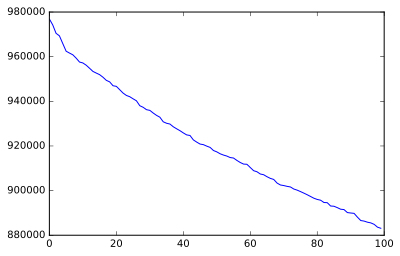

In [10]:
# And the power spectrum is basically flat. It goes
# down a bit because of aliasing effects (I think).
# (The scale is off -- I need to fix that -- but
# for now, just notice that the minimum value is 
# only 10% lower than the maximum value.)

plt.plot(s[0:100])
plt.show()

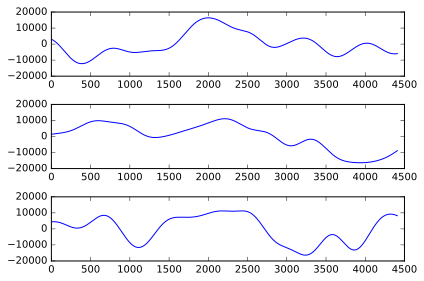

In [11]:
# So we've seen that the SVD creates sinusoidal eigenfunctions
# when we use Brownian noise, and random eigenfunctions when we
# use white noise. What about when we use a mixture of 
# deterministic functions and brownian noise? Let's start
# by creating some random base modes:

base_modes = [noise.white_squarefilter(sample_width=0.035).wav().reshape(-1, 1) / 2
              for x in range(3)]
xbins = 10
ybins = 5
plt.subplot(3, 1, 1)
plt.plot(base_modes[0])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 2)
plt.plot(base_modes[1])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 3)
plt.plot(base_modes[2])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.tight_layout()
plt.show()

# Here's what they look like:

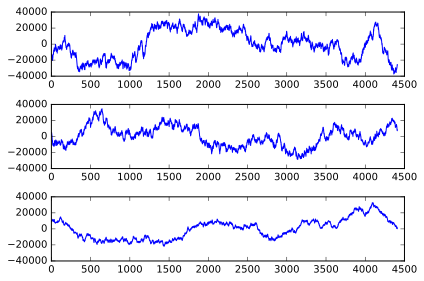

In [12]:
# Now we pick a random base mode and add some Brownian
# noise to it...

selector = numpy.random.random(len(base_modes[0])) * 3
selector = selector.astype('int')
modes = [base_modes[x] for x in selector]
fixed_arcs = [noise.brownian().wav().reshape(-1, 1) + mode 
              for x, mode in zip(range(2000), modes)]

fixed_arcs = numpy.hstack(fixed_arcs)

plt.subplot(3, 1, 1)
plt.plot(fixed_arcs[:,0])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 2)
plt.plot(fixed_arcs[:,1])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 3)
plt.plot(fixed_arcs[:,2])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.tight_layout()
plt.show()

# It's hard to tell the difference between this and 
# plain old Brownian noise, right? 

In [13]:
U, s, V = numpy.linalg.svd(fixed_arcs, full_matrices=False)
numpy.allclose(fixed_arcs, U @ numpy.diag(s) @ V)

True

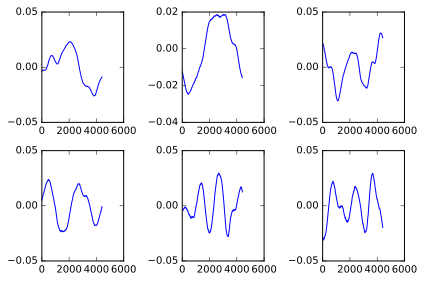

In [14]:
nbins = 3
plt.subplot(2, 3, 1)
plt.plot(U[:,0].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 2)
plt.plot(U[:,1].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 3)
plt.plot(U[:,2].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 4)
plt.plot(U[:,3].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 5)
plt.plot(U[:,4].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 6)
plt.plot(U[:,5].reshape(-1))
plt.locator_params(nbins=nbins)
plt.tight_layout()
plt.show()

# But not to the SVD! It picks up right away that there's
# some hidden structure here: